# AWQ on LLaVA

In this notebook, we use LLaVA model to demonstrate the performance of AWQ on multi-modal models. We implement AWQ real-INT4 inference kernels, which are wrapped as Pytorch modules and can be easily used by existing models. We also provide a simple example to show how to use AWQ to quantize a model and save/load the quantized model checkpoint.

In order to run this notebook, you need to install the following packages:
- [AWQ](https://github.com/mit-han-lab/llm-awq)
- [Pytorch](https://pytorch.org/)
- [Accelerate](https://github.com/huggingface/accelerate)
- [LLaVA](https://github.com/haotian-liu/LLaVA)
- [Transformers](https://github.com/huggingface/transformers)

In [37]:
import torch
import numpy as np

from PIL import Image
import gc
import requests
from io import BytesIO

from transformers import AutoConfig, AutoTokenizer
from accelerate import load_checkpoint_and_dispatch

from awq.quantize.pre_quant import run_awq, apply_awq
from awq.quantize.quantizer import real_quantize_model_weight

from tinychat.utils.load_quant import load_awq_model
from tinychat.utils.tune import device_warmup, tune_all_wqlinears
from tinychat.utils.prompt_templates import get_prompter, get_stop_token_ids
from tinychat.utils.llava_image_processing import process_images, load_image
from tinychat.models.llava_llama import LlavaLlamaForCausalLM
from tinychat.stream_generators.llava_stream_gen import LlavaStreamGenerator
from tinychat.modules import make_quant_norm, make_quant_attn, make_fused_mlp, make_fused_vision_attn

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# This demo only support single GPU for now

model_path = "/dataset/llava/llava-v1.5-7b"  # Please change here 
quant_path = "../quant_cache/llava-v1.5-7b-w4-g128-awq.pt"  # place to dump quant weights

device = "cuda"

Please get the LLaVA model from [LLaVA](https://github.com/haotian-liu/LLaVA) and run the following cell to generate a quantized model checkpoint first (note that we only quantize the language decoder, which dominates the model parameter as well as **the generation speed**). 

In [38]:
# Skip this part if the quantized checkpoints are ready.

from llava.model import LlavaLlamaForCausalLM as LlavaLlamaForCausalLMFP16
model = LlavaLlamaForCausalLMFP16.from_pretrained(model_path, low_cpu_mem_usage=True, torch_dtype=torch.float16, use_cache=True).cuda()

awq_results = torch.load("../awq_cache/llava-v1.5-7b-w4-g128.pt", map_location="cpu")  # Please change here 
apply_awq(model, awq_results)

real_quantize_model_weight(model, w_bit=4, q_config={"zero_point": True, "q_group_size": 128})
torch.save(model.cpu().state_dict(), quant_path)

del model
gc.collect()
torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

real weight quantization...: 100%|██████████| 32/32 [02:41<00:00,  5.05s/it]


We then load the quantized llava model. We first initialize an empty model and replace all the linear layers with WQLinear layers. After that, we load the quantized weights from the checkpoint. 

In [39]:
def skip(*args, **kwargs):
    pass
    
# Accelerate model initialization
setattr(torch.nn.Linear, "reset_parameters", lambda self: None)
setattr(torch.nn.LayerNorm, "reset_parameters", lambda self: None)
torch.nn.init.kaiming_uniform_ = skip
torch.nn.init.kaiming_normal_ = skip
torch.nn.init.uniform_ = skip
torch.nn.init.normal_ = skip

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
model = LlavaLlamaForCausalLM(config, device).half() 

# load the vision_tower
vision_tower = model.get_model().vision_tower
if not vision_tower.is_loaded:
    vision_tower.load_model()
image_processor = vision_tower.image_processor

# load quantized model
model = load_awq_model(model, quant_path, 4, 128, device)

# optimize for inference speed
make_quant_attn(model, device)
make_quant_norm(model)
make_fused_mlp(model)
model = model.to(device)

Loading checkpoint: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Now, let's define the configurations for the conversation.

In [40]:
# Conversation parameters
from attributedict.collections import AttributeDict
gen_params = AttributeDict(
    [
        ("seed", -1),  # RNG seed
        ("n_threads", 1),  # TODO: fix this
        ("n_predict", 512),  # new tokens to predict
        ("n_parts", -1),  # amount of model parts (-1: determine from model dimensions)
        ("n_ctx", 512),  # context size
        ("n_batch", 512),  # batch size for prompt processing (must be >=32 to use BLAS)
        ("n_keep", 0),  # number of tokens to keep from initial prompt
        ("n_vocab", 50272),  # vocabulary size
        # sampling parameters
        ("logit_bias", dict()),  # logit bias for specific tokens: <int, float>
        ("top_k", 40),  # <= 0 to use vocab size
        ("top_p", 0.95),  # 1.0 = disabled
        ("tfs_z", 1.00),  # 1.0 = disabled
        ("typical_p", 1.00),  # 1.0 = disabled
        ("temp", 0.20),  # 1.0 = disabled
        ("repeat_penalty", 1.10),  # 1.0 = disabled
        (
            "repeat_last_n",
            64,
        ),  # last n tokens to penalize (0 = disable penalty, -1 = context size)
        ("frequency_penalty", 0.00),  # 0.0 = disabled
        ("presence_penalty", 0.00),  # 0.0 = disabled
        ("mirostat", 0),  # 0 = disabled, 1 = mirostat, 2 = mirostat 2.0
        ("mirostat_tau", 5.00),  # target entropy
        ("mirostat_eta", 0.10),  # learning rate
    ]
)

We add the output streamer to manage the generation process.

In [41]:
def stream_output(output_stream):
    print(f"ASSISTANT: ", end="", flush=True)
    pre = 0
    for outputs in output_stream:
        output_text = outputs["text"]
        output_text = output_text.strip().split(" ")
        now = len(output_text) - 1
        if now > pre:
            print(" ".join(output_text[pre:now]), end=" ", flush=True)
            pre = now
    print(" ".join(output_text[pre:]), flush=True)
    if "timing" in outputs and outputs["timing"] is not None:
        timing = outputs["timing"]
        context_tokens = timing["context_tokens"]
        context_time = timing["context_time"]
        total_tokens = timing["total_tokens"]
        generation_time_list = timing["generation_time_list"]
        generation_tokens = len(generation_time_list)
        average_speed = (context_time + np.sum(generation_time_list)) / (
            context_tokens + generation_tokens
        )
        print("=" * 50)
        print("Speed of Inference")
        print("-" * 50)
        print(
            f"Generation Stage : {np.average(generation_time_list) * 1000:.2f} ms/token"
        )
        print("=" * 50)
    return " ".join(output_text)

Then input a image link and a question below.

## Q: What is unusual about this image?

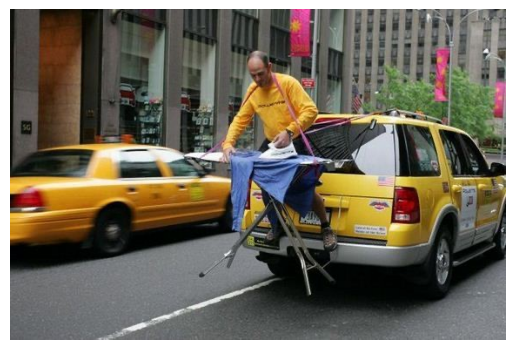

In [42]:
query = "What is unusual about this image?"
image_file = "https://llava.hliu.cc/file=/nobackup/haotian/code/LLaVA/llava/serve/examples/extreme_ironing.jpg" 

def load_image(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

# show the image
import matplotlib.pyplot as plt
image = load_image(image_file)
plt.imshow(image)
plt.axis('off')
plt.show()

# preprocess the image tensor
image_tensor = process_images([image], image_processor, model.config)
if type(image_tensor) is list:
    image_tensor = [image.to(device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(device, dtype=torch.float16)

Finally, we can use the model for generation.

In [44]:
stream_generator = LlavaStreamGenerator

model_prompter = get_prompter('llama', model_path, short_prompt=False)
stop_token_ids = get_stop_token_ids('llama', model_path)

print(f"USER: {query}")
# Insert image token
model_prompter.insert_prompt("<image>\n" + query)
output_stream = stream_generator(
    model,
    tokenizer,
    model_prompter.model_input,
    gen_params,
    device=device,
    stop_token_ids=stop_token_ids,
    image_tensor=image_tensor,
)
outputs = stream_output(output_stream)

USER: What is unusual about this image?
ASSISTANT: In this image, what is unusual is that a man is sitting on top of a clothes drying rack attached to the back of a yellow SUV taxi. This is not a typical sight on city streets, as people usually do not use their vehicles as makeshift clothes drying racks or transportation for such purposes. It appears that the man has chosen to dry his clothes in public while traveling in his taxi, which adds an unconventional element to the scene.
Speed of Inference
--------------------------------------------------
Generation Stage : 7.56 ms/token
